Enter start x position: 2
Enter start y position: 3
Enter goal x position: 17
Enter goal y position: 18


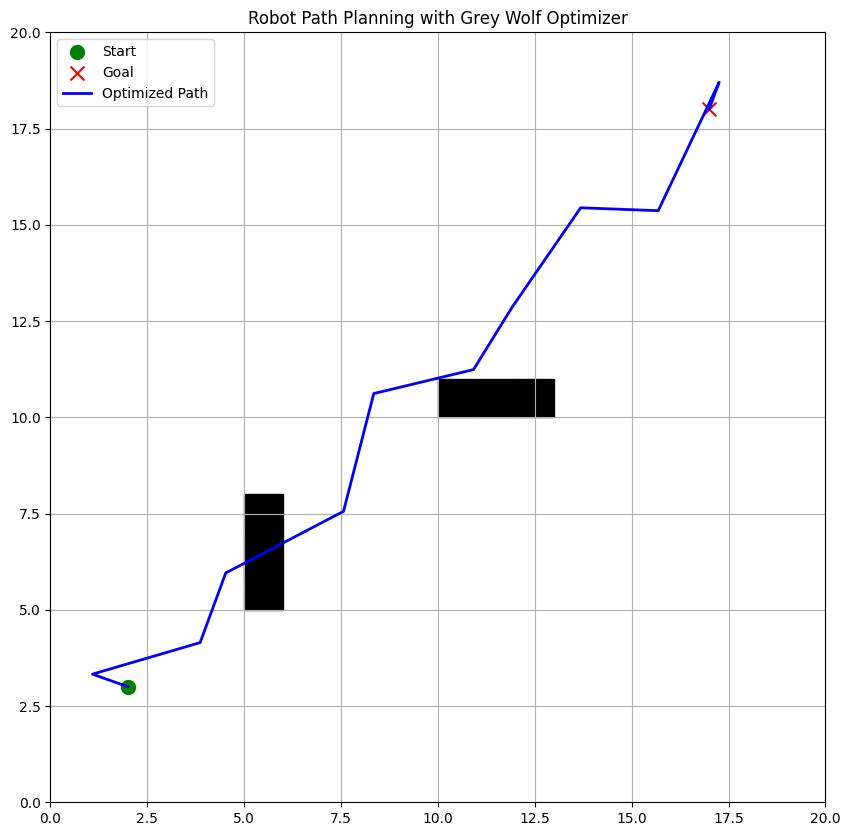

Best Path Fitness (Path Length): 21.911213435206456
Sparsha Srinath Kadaba - 1BM22CS287


In [12]:
# 5. Grey Wolf Optimizer (GWO):
# Application - Robotic and Path Planning

import numpy as np
import matplotlib.pyplot as plt

class GridEnvironment:
    def __init__(self, width, height, obstacles, start, goal):
        self.width = width
        self.height = height
        self.obstacles = obstacles
        self.start = start
        self.goal = goal

    def plot_grid(self, path=None):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)

        # Plot obstacles
        for obs in self.obstacles:
            ax.add_patch(plt.Rectangle((obs[0], obs[1]), 1, 1, color='black'))

        # Plot start and goal
        ax.scatter(self.start[0], self.start[1], color='green', label='Start', s=100, marker='o')
        ax.scatter(self.goal[0], self.goal[1], color='red', label='Goal', s=100, marker='x')

        # Plot path if available
        if path is not None:
            path = np.array(path)
            ax.plot(path[:, 0], path[:, 1], color='blue', lw=2, label='Optimized Path')

        ax.set_title("Robot Path Planning with Grey Wolf Optimizer")
        ax.legend()
        plt.grid(True)
        plt.show()


class GreyWolfOptimizer:
    def __init__(self, n_wolves, max_iter, bounds, env):
        self.n_wolves = n_wolves
        self.max_iter = max_iter
        self.bounds = bounds
        self.env = env
        self.alpha_idx = None  # Index of the best wolf (alpha)
        self.beta_idx = None   # Index of the second-best wolf (beta)
        self.delta_idx = None  # Index of the third-best wolf (delta)
        self.wolves = self.initialize_wolves()
        self.fitness = np.inf * np.ones(n_wolves)

    def initialize_wolves(self):
        """Initialize wolves' paths as a series of waypoints between start and goal."""
        # Start and goal points
        start = self.env.start
        goal = self.env.goal
        # Initialize wolves' paths between start and goal
        wolves = np.zeros((self.n_wolves, 4))  # (x_start, y_start, x_goal, y_goal)
        for i in range(self.n_wolves):
            # Perturb the path randomly with some noise
            wolves[i, 0] = start[0] + np.random.uniform(-2, 2)
            wolves[i, 1] = start[1] + np.random.uniform(-2, 2)
            wolves[i, 2] = goal[0] + np.random.uniform(-2, 2)
            wolves[i, 3] = goal[1] + np.random.uniform(-2, 2)
        return wolves

    def fitness_function(self, path):
        # Calculate path length and penalize for collisions
        total_distance = 0
        for i in range(len(path) - 1):
            total_distance += self.euclidean_distance(path[i], path[i + 1])

        # Penalty for collisions (if any point intersects an obstacle)
        collision_penalty = 0
        for point in path:
            if self.is_collision(point):
                collision_penalty += 1000  # High penalty for collision

        return total_distance + collision_penalty

    def euclidean_distance(self, point1, point2):
        return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    def is_collision(self, point):
        for obs in self.env.obstacles:
            if (obs[0] <= point[0] < obs[0] + 1) and (obs[1] <= point[1] < obs[1] + 1):
                return True
        return False

    def update_positions(self, alpha, beta, delta, t):
        a = 2 - 2 * (t / self.max_iter)  # Control parameter (decay over time)

        for i in range(self.n_wolves):
            r1, r2 = np.random.rand(), np.random.rand()
            A = 2 * a * r1 - a  # Coefficient for exploration
            C = 2 * r2  # Coefficient for exploitation

            # Update positions of wolves
            D_alpha = abs(C * alpha[0] - self.wolves[i, 0]), abs(C * alpha[1] - self.wolves[i, 1])
            D_beta = abs(C * beta[0] - self.wolves[i, 0]), abs(C * beta[1] - self.wolves[i, 1])
            D_delta = abs(C * delta[0] - self.wolves[i, 0]), abs(C * delta[1] - self.wolves[i, 1])

            self.wolves[i, 0] = (alpha[0] + beta[0] + delta[0]) / 3
            self.wolves[i, 1] = (alpha[1] + beta[1] + delta[1]) / 3

            # Clip positions to stay within bounds
            self.wolves[i, 0] = np.clip(self.wolves[i, 0], self.bounds[0][0], self.bounds[1][0])
            self.wolves[i, 1] = np.clip(self.wolves[i, 1], self.bounds[0][1], self.bounds[1][1])

    def optimize(self):
        for t in range(self.max_iter):
            for i in range(self.n_wolves):
                # Convert wolf position to a path and evaluate its fitness
                path = self.generate_path(self.wolves[i])
                fitness = self.fitness_function(path)

                if fitness < self.fitness[i]:
                    self.fitness[i] = fitness
                    if self.alpha_idx is None or fitness < self.fitness[self.alpha_idx]:
                        self.alpha_idx = i
                    elif self.beta_idx is None or fitness < self.fitness[self.beta_idx]:
                        self.beta_idx = i
                    elif self.delta_idx is None or fitness < self.fitness[self.delta_idx]:
                        self.delta_idx = i

            alpha = self.wolves[self.alpha_idx]
            beta = self.wolves[self.beta_idx]
            delta = self.wolves[self.delta_idx]

            self.update_positions(alpha, beta, delta, t)

        best_path = self.generate_path(self.wolves[self.alpha_idx])
        return best_path, self.fitness[self.alpha_idx]

    def generate_path(self, wolf):
        """Generate a path from start to goal with some random perturbation."""
        start = self.env.start
        goal = self.env.goal
        path = [start]
        for t in np.linspace(0, 1, num=10):  # Create 10 waypoints between start and goal
            x = start[0] + t * (goal[0] - start[0]) + np.random.uniform(-1, 1)
            y = start[1] + t * (goal[1] - start[1]) + np.random.uniform(-1, 1)
            path.append((x, y))
        path.append(goal)
        return path


def main():
    # Define grid environment
    width, height = 20, 20
    obstacles = [(5, 5), (5, 6), (5, 7), (10, 10), (11, 10), (12, 10)]

    # Take user input for start and goal positions
    start_x = int(input("Enter start x position: "))
    start_y = int(input("Enter start y position: "))
    goal_x = int(input("Enter goal x position: "))
    goal_y = int(input("Enter goal y position: "))

    # Ensure start and goal are within grid bounds
    if not (0 <= start_x < width and 0 <= start_y < height):
        print("Start position is out of bounds!")
        return
    if not (0 <= goal_x < width and 0 <= goal_y < height):
        print("Goal position is out of bounds!")
        return

    start = (start_x, start_y)
    goal = (goal_x, goal_y)

    env = GridEnvironment(width, height, obstacles, start, goal)

    # Define Grey Wolf Optimizer parameters
    n_wolves = 10
    max_iter = 50
    bounds = [(0, 0), (width, height)]  # Limits for waypoints (x, y)

    gwo = GreyWolfOptimizer(n_wolves, max_iter, bounds, env)

    # Perform optimization
    best_path, best_fitness = gwo.optimize()

    # Plot the result
    env.plot_grid(path=best_path)
    print("Best Path Fitness (Path Length):", best_fitness)

if __name__ == "__main__":
    main()

print("Sparsha Srinath Kadaba - 1BM22CS287")